In [70]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
sys.path.append("./utils")

from utils.dnn_utils import StockSequenceDataset, StockDataset,\
                            StockLSTMModel, StockDenseRegressionModel,\
                            train_model, get_test_logits
from utils.get_targets import get_first_threshold_bump, get_close_price_target

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

from stockstats import StockDataFrame
import talib

import torch
from torch import nn
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import optuna
pd.set_option("display.max_columns", None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current device: cuda


In [66]:
DATA_PATH = "./data/prices/BTC_1minute_train.csv"
TEST_PATH = "./data/prices/BTC_1minute_test.csv"

train_data = pd.read_csv(DATA_PATH, index_col=0)
train_data

,volume,open,close,high,low,date,ticker
0,19.242033,7387.23,7383.66,7393.17,7368.68,2020-04-08 23:43:00,X:BTCUSD
1,18.150259,7380.30,7379.70,7387.25,7367.68,2020-04-08 23:44:00,X:BTCUSD
2,18.564893,7380.00,7374.40,7386.49,7365.78,2020-04-08 23:45:00,X:BTCUSD
3,74.808246,7364.26,7373.59,7380.21,7362.68,2020-04-08 23:46:00,X:BTCUSD
4,43.765348,7375.00,7366.50,7377.00,7355.39,2020-04-08 23:47:00,X:BTCUSD
...,...,...,...,...,...,...,...
828795,10.737749,66926.65,67029.33,67044.51,66918.64,2021-11-09 23:55:00,X:BTCUSD
828796,7.193794,67029.08,66991.61,67029.08,66977.20,2021-11-09 23:56:00,X:BTCUSD
828797,6.154340,66991.62,66982.08,67003.41,66978.05,2021-11-09 23:57:00,X:BTCUSD
828798,6.868476,66986.95,66922.37,66991.49,66922.37,2021-11-09 23:58:00,X:BTCUSD


In [67]:
# ['macd', 'macds', 'macds_5_ema', 'macds_5_mstd', 'macds_10_ema',
#        'macds_20_ema', 'rsi', 'rsi_6', 'volume_5_ema', 'close_5_mstd',
#        'close_15_mstd', 'close_20_mstd', 'close_30_mstd', 'trix',
#        'middle_10_trix', 'wr', 'wr_6', 'atr', 'atr_5', 'volume', 'target']

# BAD!
# ['macdh_5_ema', 'macdh_5_mstd', 'macdh_10_ema', 'macdh_10_mstd',
#        'macds_10_mstd', 'macds_20_mstd', 'volume_10_mstd', 'pdi', 'mdi', 'dx',
#        'adx', 'adxr', 'cr', 'cr-ma1', 'cr-ma2', 'cr-ma3', 'middle', 'boll',
#        'boll_ub', 'boll_lb', 'ppoh', 'vwma', 'vwma_6', 'chop', 'chop_6', 'mfi',
#        'mfi_6', 'close_10_kama', 'close']

# Correlation |.| < 0.025
# BAD macdh, rsi_5_mstd, rsi_5_ema, ..., stochrsi, supertrend, close_ema, tema, vr, cci, supertrend

def get_features(dataset: pd.DataFrame) -> pd.DataFrame:
    indicators = [
        "macd", "macds",
        "macd_5_ema", "macd_5_mstd", "macd_10_ema", "macd_10_mstd",
        "macds_5_ema", "macds_10_ema", "macds_20_ema", "macds_5_mstd",
        "rsi", "rsi_6",
        "volume_5_ema", "volume_10_ema", "volume_20_ema", "volume_10_mstd",
        "close_5_mstd", "close_15_mstd", "close_20_mstd", "close_30_mstd",
        "trix", "middle_10_trix",
        "wr", "wr_6",
        "atr", "atr_5",
        "dma",
        "ppo", "ppos",
        "volume", "close",
    ]
    
    result_dataset = StockDataFrame(dataset.copy())
    
    result_dataset["apo"] = talib.APO(result_dataset["close"])
    result_dataset["bop"] = talib.BOP(result_dataset["open"], result_dataset["high"], result_dataset["low"],
                                     result_dataset["close"])
    result_dataset["cmo"] = talib.CMO(result_dataset["close"])
    result_dataset["minus_dm"] = talib.MINUS_DM(result_dataset["high"], result_dataset["low"])
    result_dataset["mom"] = talib.MOM(result_dataset["close"])
    result_dataset["willr"] = talib.WILLR(result_dataset["high"], result_dataset["low"],
                                     result_dataset["close"])
    
    additional_columns = ["apo", "bop", "cmo", "minus_dm", "mom", "willr"]
    
    return result_dataset[indicators + additional_columns]

In [73]:
POWER = 0.01
TIME_LAG = 5

data_preprocessed = get_features(train_data).dropna().reset_index(drop=True)
data_preprocessed = data_preprocessed.join(pd.Series(get_close_price_target(data_preprocessed, TIME_LAG), name="target"))
data_preprocessed.dropna(inplace=True)
data_preprocessed

,macd,macds,macd_5_ema,macd_5_mstd,macd_10_ema,macd_10_mstd,macds_5_ema,macds_10_ema,macds_20_ema,macds_5_mstd,rsi,rsi_6,volume_5_ema,volume_10_ema,volume_20_ema,volume_10_mstd,close_5_mstd,close_15_mstd,close_20_mstd,close_30_mstd,trix,middle_10_trix,wr,wr_6,atr,atr_5,dma,ppo,ppos,volume,close,apo,bop,cmo,minus_dm,mom,willr,target
0,-5.291128,-4.734408,-5.310957,0.231455,-4.597414,1.599099,-4.149456,-3.439488,-2.714894,0.519069,41.511280,49.419090,20.198971,26.713885,30.979281,49.601714,3.135655,12.952985,12.328559,15.102206,-0.018348,-0.019510,-63.287443,-25.226001,17.825505,15.749005,-15.354480,-0.071989,-0.064388,18.865032,7344.10,-11.311480,0.133779,-20.547184,42.357681,-24.72,-63.287443,-4.33
1,-5.199611,-4.827675,-5.273841,0.296342,-4.707393,1.108288,-4.375533,-3.693010,-2.930574,0.366347,38.767288,40.933858,18.275296,24.470144,29.289678,49.321413,2.636181,12.228312,12.519513,15.173173,-0.018094,-0.018698,-71.233480,-46.250524,17.560742,15.522657,-16.862499,-0.070753,-0.065664,14.428048,7339.56,-11.522826,-0.339945,-24.929258,41.352132,-21.44,-71.233480,9.83
2,-4.643627,-4.790794,-5.063767,0.474933,-4.695757,0.743946,-4.513955,-3.893334,-3.119180,0.211894,43.976483,53.459049,24.091195,26.523531,29.941926,31.131794,3.059962,10.426216,12.192017,15.023825,-0.017387,-0.017382,-57.325843,-24.899920,17.258449,15.189481,-15.964732,-0.063190,-0.065168,35.722788,7345.49,-12.151224,-0.026696,-15.934939,38.398409,5.19,-57.325843,-1.79
3,-4.651783,-4.762948,-4.926438,0.465822,-4.687738,0.516724,-4.596953,-4.051916,-3.284821,0.089323,39.751200,41.273783,20.276106,23.992833,28.199029,9.649630,3.109175,10.517379,12.419875,15.091226,-0.016740,-0.016186,-72.786517,-58.508263,17.111418,15.239663,-15.562844,-0.063308,-0.064796,12.646017,7338.61,-12.640519,-0.413860,-22.872866,39.995665,-1.88,-72.786517,8.28
4,-4.593265,-4.728970,-4.815380,0.339583,-4.670519,0.490307,-4.640959,-4.175317,-3.429547,0.041089,39.886810,41.621918,19.766534,23.036795,27.251833,9.102365,3.244662,9.356948,12.429075,15.126829,-0.016101,-0.015236,-72.449438,-63.418217,16.813333,14.869272,-14.801283,-0.062518,-0.064340,18.747398,7338.76,-11.429236,0.415982,-22.635228,39.358832,2.16,-72.449438,4.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828765,-70.143974,-45.013764,-52.135108,15.832901,-43.681951,13.007945,-37.892419,-33.027448,-26.448922,5.615896,24.976669,13.811859,43.971376,32.826107,23.807227,34.773775,108.419603,94.359070,103.652296,114.448065,-0.012109,-0.013336,-84.979605,-83.643038,87.615816,119.873814,-122.566600,-0.104479,-0.067014,32.801163,66872.67,-73.438397,-0.718818,-50.046662,430.314618,-252.23,-84.979605,156.66
828766,-83.153074,-52.641626,-62.474430,19.103417,-50.858519,18.595066,-42.808822,-36.593662,-28.943465,8.262269,23.474347,12.189436,33.086657,28.915401,22.617703,34.536495,100.278752,114.899987,118.209618,128.872771,-0.014442,-0.016510,-92.650799,-91.384635,86.428972,110.099051,-139.052800,-0.123897,-0.078391,11.317220,66838.46,-80.894295,-0.514930,-53.051306,440.577859,-270.68,-92.650799,153.15
828767,-87.083358,-59.529972,-70.677406,18.702806,-57.444853,22.654712,-48.382538,-40.763900,-31.856466,10.188319,32.046267,31.102034,31.580979,28.852532,23.184552,34.046692,80.872859,123.168714,118.693677,134.700749,-0.016457,-0.019624,-69.355000,-64.728780,91.765474,120.307241,-158.304400,-0.129783,-0.088669,28.569623,66905.08,-84.542628,0.455629,-35.907466,486.158012,-272.43,-69.355000,77.00
828768,-91.651948,-65.954367,-77.668920,14.493702,-63.664325,25.146198,-54.239815,-45.343985,-35.103885,10.908766,30.337321,27.752508,24.327615,25.392233,21.911822,34.232526,32.941054,131.368091,122.632014,141.897045,-0.018260,-0.021979,-75.580860,-65.532047,90.562312,111.230035,-185.945000,-0.136626,-0.098260,9.820887,66873.97,-88.366667,-0.415236,-39.325359,451.432440,-356.53,-75.580860,48.40


In [104]:
(data_preprocessed["target"] < 500).sum()

827064

In [105]:
data_preprocessed.shape

(828770, 38)

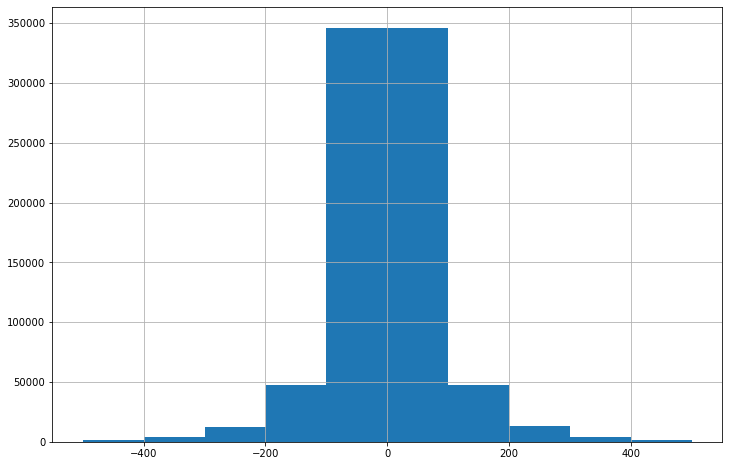

In [103]:
plt.figure(figsize=(12, 8))
target_bounded = data_preprocessed.loc[np.abs(data_preprocessed["target"]) < 500, "target"]
plt.hist(target_bounded)
plt.grid()
plt.show()

In [88]:
target_corr = data_preprocessed.corr()["target"]
print(target_corr[np.abs(target_corr) < 0.025].index)
data_preprocessed.corr()

Index(['volume_10_mstd', 'close_20_mstd', 'close_30_mstd', 'middle_10_trix',
       'atr', 'close', 'apo'],
      dtype='object')


,macd,macds,macd_5_ema,macd_5_mstd,macd_10_ema,macd_10_mstd,macds_5_ema,macds_10_ema,macds_20_ema,macds_5_mstd,rsi,rsi_6,volume_5_ema,volume_10_ema,volume_20_ema,volume_10_mstd,close_5_mstd,close_15_mstd,close_20_mstd,close_30_mstd,trix,middle_10_trix,wr,wr_6,atr,atr_5,dma,ppo,ppos,volume,close,apo,bop,cmo,minus_dm,mom,willr,target
macd,1.000000,0.950578,0.982672,-0.065273,0.941869,-0.043544,0.895830,0.831764,0.731494,-0.025333,0.627164,0.385220,-0.086467,-0.083759,-0.067558,-0.086815,-0.100369,-0.071262,-0.054922,-0.033917,0.903497,0.899775,0.310416,0.119498,-0.051028,-0.086943,0.955156,0.922703,0.877096,-0.069011,0.010664,0.908138,0.020803,0.627165,-0.418562,0.608899,0.310416,-0.036048
macds,0.950578,1.000000,0.989911,-0.083665,0.999522,-0.067514,0.988733,0.956731,0.881589,-0.047322,0.501983,0.225046,-0.082873,-0.086829,-0.077462,-0.083161,-0.106151,-0.090517,-0.074513,-0.048893,0.897668,0.848013,0.153201,0.006029,-0.065288,-0.095382,0.993670,0.877266,0.922894,-0.061993,0.011231,0.853856,-0.014395,0.501984,-0.383006,0.366950,0.153201,-0.029428
macd_5_ema,0.982672,0.989911,1.000000,-0.075733,0.985190,-0.056358,0.957548,0.907106,0.814694,-0.036324,0.551978,0.282920,-0.084280,-0.085796,-0.073260,-0.085656,-0.103947,-0.081544,-0.064826,-0.041107,0.915791,0.888700,0.213981,0.037609,-0.058804,-0.092058,0.988746,0.906800,0.913494,-0.063871,0.010872,0.901661,-0.009491,0.551979,-0.397092,0.467230,0.213981,-0.030260
macd_5_mstd,-0.065273,-0.083665,-0.075733,1.000000,-0.085308,0.845411,-0.090211,-0.095884,-0.103773,0.814824,-0.010408,0.000502,0.346999,0.350158,0.340109,0.180743,0.810132,0.812145,0.760823,0.717570,-0.061428,-0.052796,0.036431,0.047453,0.690529,0.723701,-0.078030,-0.062363,-0.078807,0.271446,0.438633,-0.049896,0.000735,-0.010404,0.679708,0.002246,0.036431,0.034257
macd_10_ema,0.941869,0.999522,0.985190,-0.085308,1.000000,-0.069931,0.992748,0.965270,0.895126,-0.049847,0.491693,0.214223,-0.082653,-0.087050,-0.078369,-0.082551,-0.106691,-0.092500,-0.076789,-0.050909,0.890765,0.836386,0.141629,0.001151,-0.066769,-0.096120,0.992100,0.869241,0.922469,-0.061731,0.011330,0.839328,-0.014952,0.491693,-0.380198,0.347822,0.141629,-0.029371
macd_10_mstd,-0.043544,-0.067514,-0.056358,0.845411,-0.069931,1.000000,-0.077819,-0.087643,-0.100443,0.967992,-0.001584,0.006682,0.322917,0.350318,0.357140,0.176705,0.677176,0.903568,0.853433,0.787693,-0.042628,-0.030466,0.044019,0.048465,0.724025,0.736946,-0.059798,-0.043660,-0.064970,0.230260,0.460981,-0.024539,-0.000812,-0.001580,0.697183,0.026026,0.044019,0.027514
macds_5_ema,0.895830,0.988733,0.957548,-0.090211,0.992748,-0.077819,1.000000,0.988181,0.932933,-0.057904,0.438159,0.158970,-0.079570,-0.086017,-0.080202,-0.078701,-0.106153,-0.098012,-0.083113,-0.056047,0.858841,0.786436,0.085629,-0.027465,-0.070706,-0.096803,0.977086,0.826829,0.912589,-0.058650,0.011364,0.784630,-0.019259,0.438159,-0.359727,0.252962,0.085629,-0.027903
macds_10_ema,0.831764,0.956731,0.907106,-0.095884,0.965270,-0.087643,0.988181,1.000000,0.974800,-0.069247,0.385680,0.114471,-0.077586,-0.085539,-0.082992,-0.074198,-0.107113,-0.105672,-0.093046,-0.065967,0.797902,0.705711,0.038364,-0.040118,-0.076699,-0.098628,0.940364,0.767732,0.883115,-0.057122,0.011729,0.684032,-0.019082,0.385681,-0.341732,0.172708,0.038364,-0.027754
macds_20_ema,0.731494,0.881589,0.814694,-0.103773,0.895126,-0.100443,0.932933,0.974800,1.000000,-0.084440,0.321782,0.072182,-0.076279,-0.085562,-0.087151,-0.068907,-0.110836,-0.116302,-0.107598,-0.083803,0.689928,0.582179,-0.003522,-0.045624,-0.086931,-0.103107,0.857128,0.674996,0.813648,-0.056285,0.012672,0.533504,-0.017250,0.321782,-0.321458,0.102229,-0.003522,-0.026021
macds_5_mstd,-0.025333,-0.047322,-0.036324,0.814824,-0.049847,0.967992,-0.057904,-0.069247,-0.084440,1.000000,0.001971,0.008251,0.310892,0.331561,0.335937,0.164554,0.629536,0.856826,0.814621,0.741553,-0.022861,-0.010515,0.041644,0.045491,0.669249,0.679642,-0.039882,-0.025976,-0.045828,0.222410,0.426418,-0.001899,0.000082,0.001975,0.643

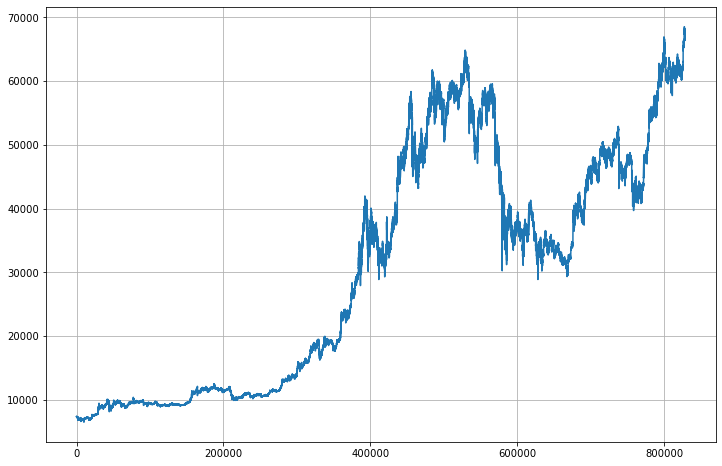

In [6]:
plt.figure(figsize=(12, 8))

plt.plot(range(data_preprocessed.shape[0]), data_preprocessed["close"])

plt.grid()
plt.show()

In [89]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2

X = data_preprocessed.drop(["target"], axis=1).to_numpy()
y = data_preprocessed["target"].to_numpy()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, shuffle=False, test_size=TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, shuffle=False, test_size=VAL_SIZE)

X_train.shape, X_val.shape, X_test.shape

((530412, 37), (132604, 37), (165754, 37))

In [90]:
BOUND = 500
X_train_bounded = X_train[np.abs(y_train) <= BOUND]
y_train_bounded = y_train[np.abs(y_train) <= BOUND]

In [91]:
cb_regressor = CatBoostRegressor(verbose=False)
cb_regressor.fit(X_train_bounded, y_train_bounded)

In [92]:
cb_predictions = regressor.predict(X_test)
mean_squared_error(y_test, cb_predictions)

12526.17468060427

In [97]:
lgbm_regressor = LGBMRegressor()
lgbm_regressor.fit(X_train_bounded, y_train_bounded)

LGBMRegressor()

In [98]:
lgbm_predictions = lgbm_regressor.predict(X_test)
mean_squared_error(y_test, lgbm_predictions)

10651.409843996174

In [130]:
(np.abs(y_test) < 2).sum()

3864

In [134]:
np.unique(test_classes, return_counts=True)

(array([0, 1, 2]), array([73387, 73339, 19028], dtype=int64))

In [135]:
test_classes = (y_test > 0).astype(int)
test_classes[np.abs(y_test) < 20] = 2
predicted_classes = (lgbm_predictions > 0).astype(int)
predicted_classes[np.abs(lgbm_predictions) < 20] = 2
confusion_matrix(test_classes, predicted_classes)

array([[ 1380,  1966, 60710],
       [ 1229,  2465, 60271],
       [  404,   784, 36545]], dtype=int64)

In [99]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train_bounded, y_train_bounded)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [100]:
xgb_predictions = xgb_regressor.predict(X_test)
mean_squared_error(y_test, xgb_predictions)

11426.646646585368